# <center> Saturation vapour pressure functions

**Aim of the notebook:**
Investigate the different saturation vapour pressure functions available in AirSeaFlux code for the COARE 3.5 parameterization



**Motivation:**
The choice of the function has sometimes a significant effect for the latent heat flux and q10n for the S88 paramaterization (see table S15 of the supplementary material of Biri et al. 2023): **is it the same for COARE 3.5?**


> ***What is the saturation vapour pressure function?***

The saturation vapour pressure function $es$ is used to compute the humidity when the humidity input is given by a relative humidy percentage or a dewpoint temperature.

Equations from the supplementary material (eq. S11):

$qz(T,P,RH)=622· (0.01 · RH · es)/(P−0.378 · (0.01 · RH · es))$

$qsea(sst,P)=622 · 0.98 · es/(P−0.378 · 0.98 · es)$

> ***What is the default method?***

Buck2 method (2012). The $es$ choice in AirSeaFlux code is given by the input parameter $qmeth$.

> ***What are the different methods available?***

There are 13 formulations for $es$ in AirSeaFluxCode. Here are the information provided by AirSeaFluxCode about $qmeth$ parameter:

    qmeth : str

    is the saturation evaporation method to use amongst
            "HylandWexler","Hardy","Preining","Wexler","GoffGratch","WMO",
            "MagnusTetens","Buck","Buck2","WMO2018","Sonntag","Bolton",
            "IAPWS","MurphyKoop"]
             default is Buck2


> ***What is reported in Biri et al. 2023 regarding the effect of $es$ used?***

In Biri et al. (2023), the investigation reported are: 
- the impact of another $es$ formulation (WMO (2018) in comparison to the default one (Buck2 (2012)) formulation - for the 10 different parameterisations (C35, S80, ...)
- the impact of the 12 alternative formulations in comparison to the default one (Buck2 (2012)) for the S88 parameterization.



# 1. Load the packages, AirSeaFluxCode and data 

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic
from tabulate import tabulate

In [2]:
# path to AirSeaFluxCode algorithm
sys.path.append('/home/jupyter-blandinejacob/ms_thesis/AirSeaFluxCode/AirSeaFluxCode-master/AirSeaFluxCode/src/')

In [3]:
from AirSeaFluxCode import AirSeaFluxCode

In [4]:
# dataset from TARSAN 2022 cruise - ship data
ds_tarsan_2022 = pd.read_csv('/home/jupyter-blandinejacob/ms_thesis/jgofs_30minmean_2022.csv')

# convert to datetime format for the plot 
ds_tarsan_2022['Time'] = pd.to_datetime(ds_tarsan_2022['Time'],format='%Y-%m-%d %H:%M:%S')

# 2. Compute the latent heat flux and humidity for the C35 parameterisation with different qmeth

In [5]:
# height of the sensors
hu = np.asarray(34.3408)
ht = np.asarray(19.2024)
hin = np.array([hu, ht, ht])

In [6]:
# list of the different formula to compute the saturation vapour pressure function
qmeth_array = ["HylandWexler","Hardy","Preining","Wexler","GoffGratch","WMO",
            "MagnusTetens","Buck","Buck2","WMO2018","Sonntag","Bolton",
            "IAPWS","MurphyKoop"]
             

In [7]:
# Loop to compute AirSeaFluxCode output for each qmeth
d = {qmeth: pd.DataFrame(AirSeaFluxCode(spd=np.asarray(ds_tarsan_2022['WindSpeed']),
               T=np.asarray(ds_tarsan_2022['AirTemp']),
               SST=np.asarray(ds_tarsan_2022['SST']),
               SST_fl='bulk',
               meth='C35',
               lat=np.asarray(ds_tarsan_2022['Lat']),
               hum=["rh",np.asarray(ds_tarsan_2022['RH'])],
               hin=hin,
               hout=10,
               Rl=np.asarray(ds_tarsan_2022['PIR']),
               Rs=np.asarray(ds_tarsan_2022['PSP']),
               cskin=1,
               skin="C35",
               wl=1,
               gust=[1,1.2,600,0.01], # x=1 follows Fairall et al. 2003 - ref paper for C35, beta,zi and ustb are the default parameters in ASFcode
               qmeth=qmeth,
               tol=['all', 0.01, 0.01, 1e-05, 1e-3, 0.1, 0.1], #default
               maxiter=10, #default
               out=0, #default
               L="tsrv", #default
               out_var=['q10n','qsea','qair','latent']
              )) 
     for qmeth in qmeth_array}

# 3 Comparisons of an alternative method with the default method

## 3.1 Latent heat flux

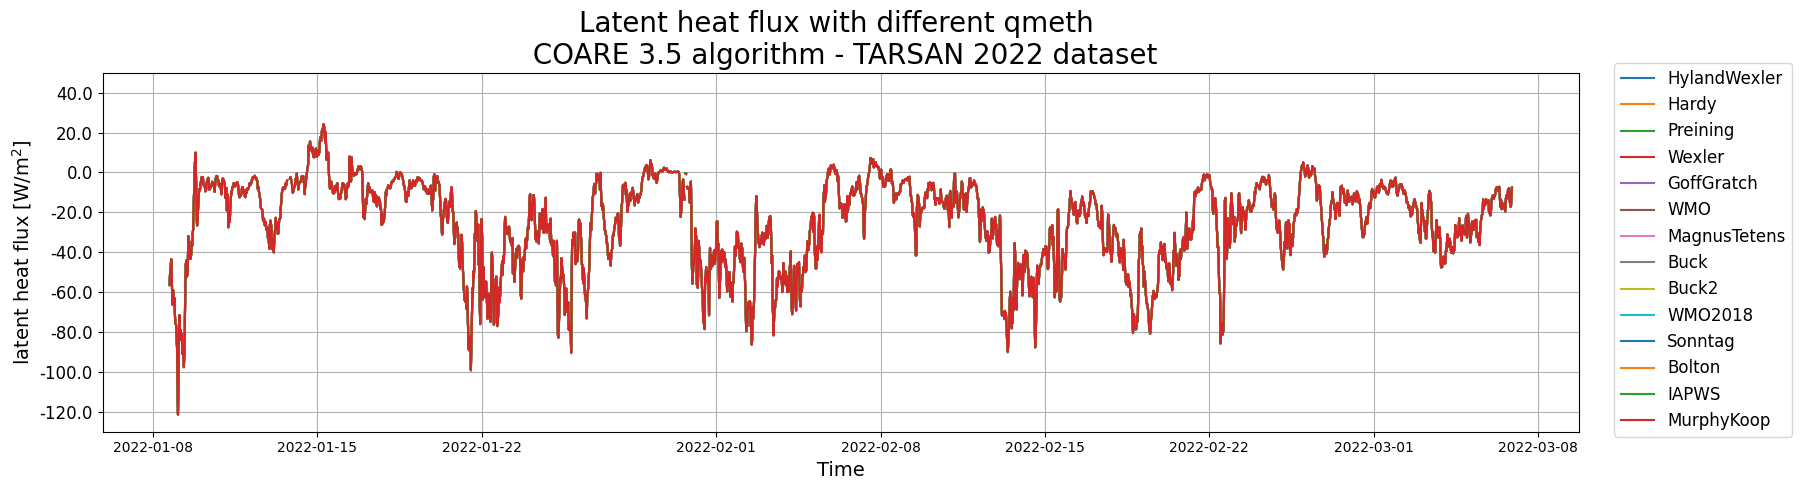

In [8]:
fig,ax= plt.subplots(nrows=1,ncols=1,figsize=(18,5))

for qmeth in d:
    ax.plot(ds_tarsan_2022['Time'],d[qmeth]['latent'],label=qmeth)
    
    
ax.legend(ncols=1,bbox_to_anchor=(1.15,1.05),fontsize=12)
ax.set_title('Latent heat flux with different qmeth \n COARE 3.5 algorithm - TARSAN 2022 dataset',fontsize=20)
ax.set_xlabel('Time',fontsize=14)

ax.set_ylabel('latent heat flux [W/m$^2$]',fontsize=14)
ax.set_yticklabels(labels=ax.get_yticks(),fontsize=12)


ax.set_ylim(-130,50)
ax.grid()


fig.tight_layout()



**Comment:** no difference visible. 

Let's take Buck2 as a reference and plot the latent heat flux (Buck 2) minus latent heat flux (other qmeth).

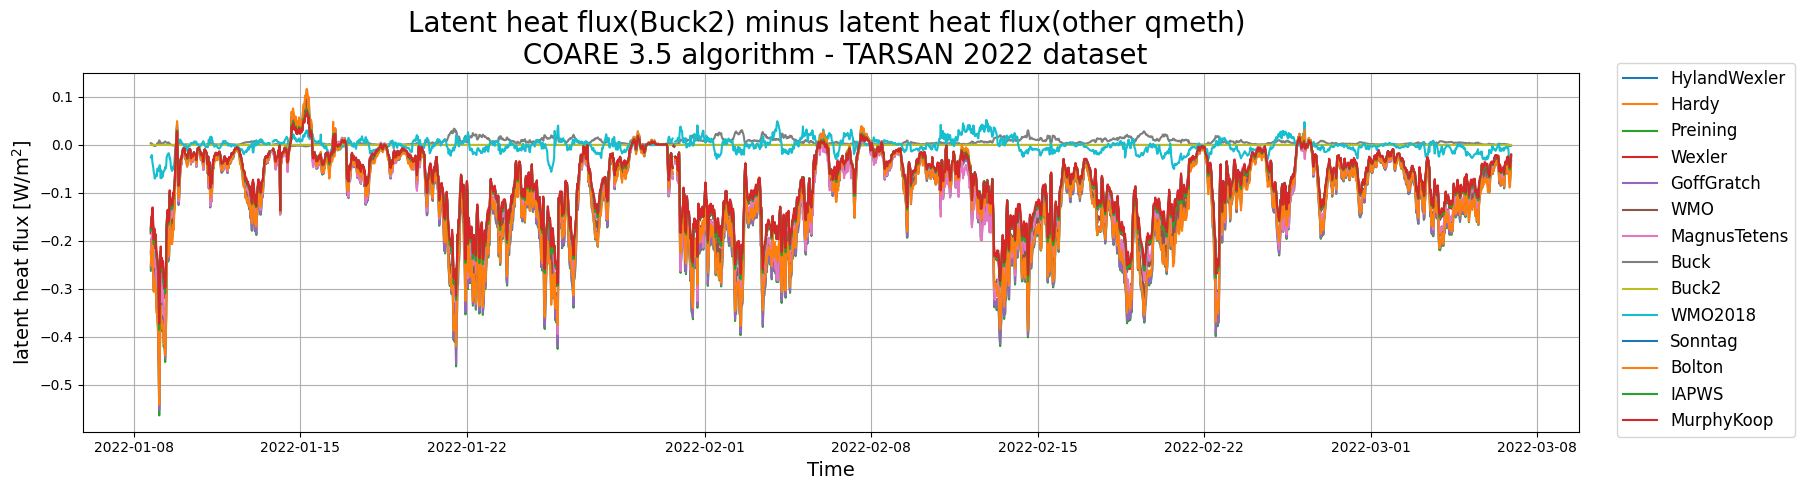

In [9]:
fig,ax= plt.subplots(nrows=1,ncols=1,figsize=(18,5))

for qmeth in d:
    ax.plot(ds_tarsan_2022['Time'],d['Buck2']['latent']-d[qmeth]['latent'],label=qmeth)


ax.legend(ncols=1,bbox_to_anchor=(1.15,1.05),fontsize=12)
ax.set_title('Latent heat flux(Buck2) minus latent heat flux(other qmeth) \n COARE 3.5 algorithm - TARSAN 2022 dataset',fontsize=20)
ax.set_xlabel('Time',fontsize=14)
ax.set_ylabel('latent heat flux [W/m$^2$]',fontsize=14)
#ax.set_ylim(-130,50)
ax.grid()
#ax.set_yticklabels(labels=ax.get_yticks(),fontsize=12)

fig.tight_layout()




**Comments:** 
- We observe two groups: 
    - one similar to Buck2 with: Buck, WMO2018,
    - the other with HylandWexler, MurphyKoop ,Bolton, GoffGratch, Hardy, IAPWS, MagnusTetens, Preining, Sonntag, WMO, Wexler
- Order of magnitude of the difference:
    - for the first group: $O(10^{-2})$
    - for the second group: $O(10^{-1})$
    
**We follow below the method implemented in Biri et al. 2023 to classify the effect of the change of method:**

In [10]:
# cf table 2 Biri et al. 2023 
tol_lhf= 0.1
significance_lhf = 2

# cf Results section - 2nd paragraph Biri et al. 2023
bins = [-10**10,-5*significance_lhf,-significance_lhf,-tol_lhf,-0.1*tol_lhf, 0.1*tol_lhf, tol_lhf,significance_lhf,5*significance_lhf,10**10]
bins_label = ['major effect (-)','significant effect (-)','insignificant effect (-)','negligible effect (-)','no effect','negligible effect (+)','insignificant effect (+)','significant effect (+)','major effect (+)']


In [11]:
# Print the results in a .txt file


print('The following tables display the effect of chosing an alternative qmethod in comparison to the qmethod of reference (Buck2) on the latent heat flux.\n'
      'The classification of the effect follows the one established in table 8 of the AirSeaFluxCode reference paper (Biri et al. 2023). \n'
      'The results of the effect are given as a count. For information, the total number of values is {}. \n \n'.format(len(ds_tarsan_2022['Time'])),
      file=open('./lhf_results.txt', 'w'))                   

print("Input summary", file=open('./lhf_results.txt', 'a'))                          
print('input file: {}, \n method: {}, \n sst type: {}, \n gustiness: {}, \n cskin: {},\n skin: {}, \n warm layer: {},'
      ' \n tolerance: {}, \n L: {},\n hout: {}, \n qmeth_ref: {}, \n \n'.format("jgofs_30minmean_2022.csv", "C35","bulk", "on",
                                                           1, "C35",1,"all", "tsrv","10","Buck2"),
      file=open('./lhf_results.txt', 'a'))



for qmeth in d:
    
    
    temp_stat = binned_statistic(d[qmeth]['latent']-d['Buck2']['latent'],d[qmeth]['latent']- d['Buck2']['latent'],
                             statistic='count', 
                             bins=bins)
    temp_data = {'Count': temp_stat.statistic}
    
   
                            
    ttl = np.asarray(["major effect (-)  ", "significant effect (-) ", "insignificant effect (-)", "negligible effect (-)", "no effect", "negligible effect (+)","insignificant effect (+)","significant effect (+)","major effect (+)"])

    header = ["Latent heat flux",qmeth]
    stats = np.copy(ttl)


    stats = np.c_[stats,temp_stat.statistic]                           


    print(tabulate(stats, headers=header, tablefmt="github", numalign="left",
                   floatfmt=("s", ".0f", "2f", "2f", "2f", "2f", "2f","2f","2f","2f")),
      file=open('./lhf_results.txt', 'a'))
    
    print('-'*79+'\n', file=open('./lhf_results.txt', 'a'))
    print('-'*79+'\n', file=open('./lhf_results.txt', 'a'))



## 3.2 Humidity output

We focus now on the humidity outputs: the specific humidity at sea surface (qsea), specific humidity of air (qair) and the 10m neutral specific humidity (q10n).

We use the effect's classification created for the paramater q10n in the table 8 of Biri et al. 2023 for q10n but also qsea and qair.

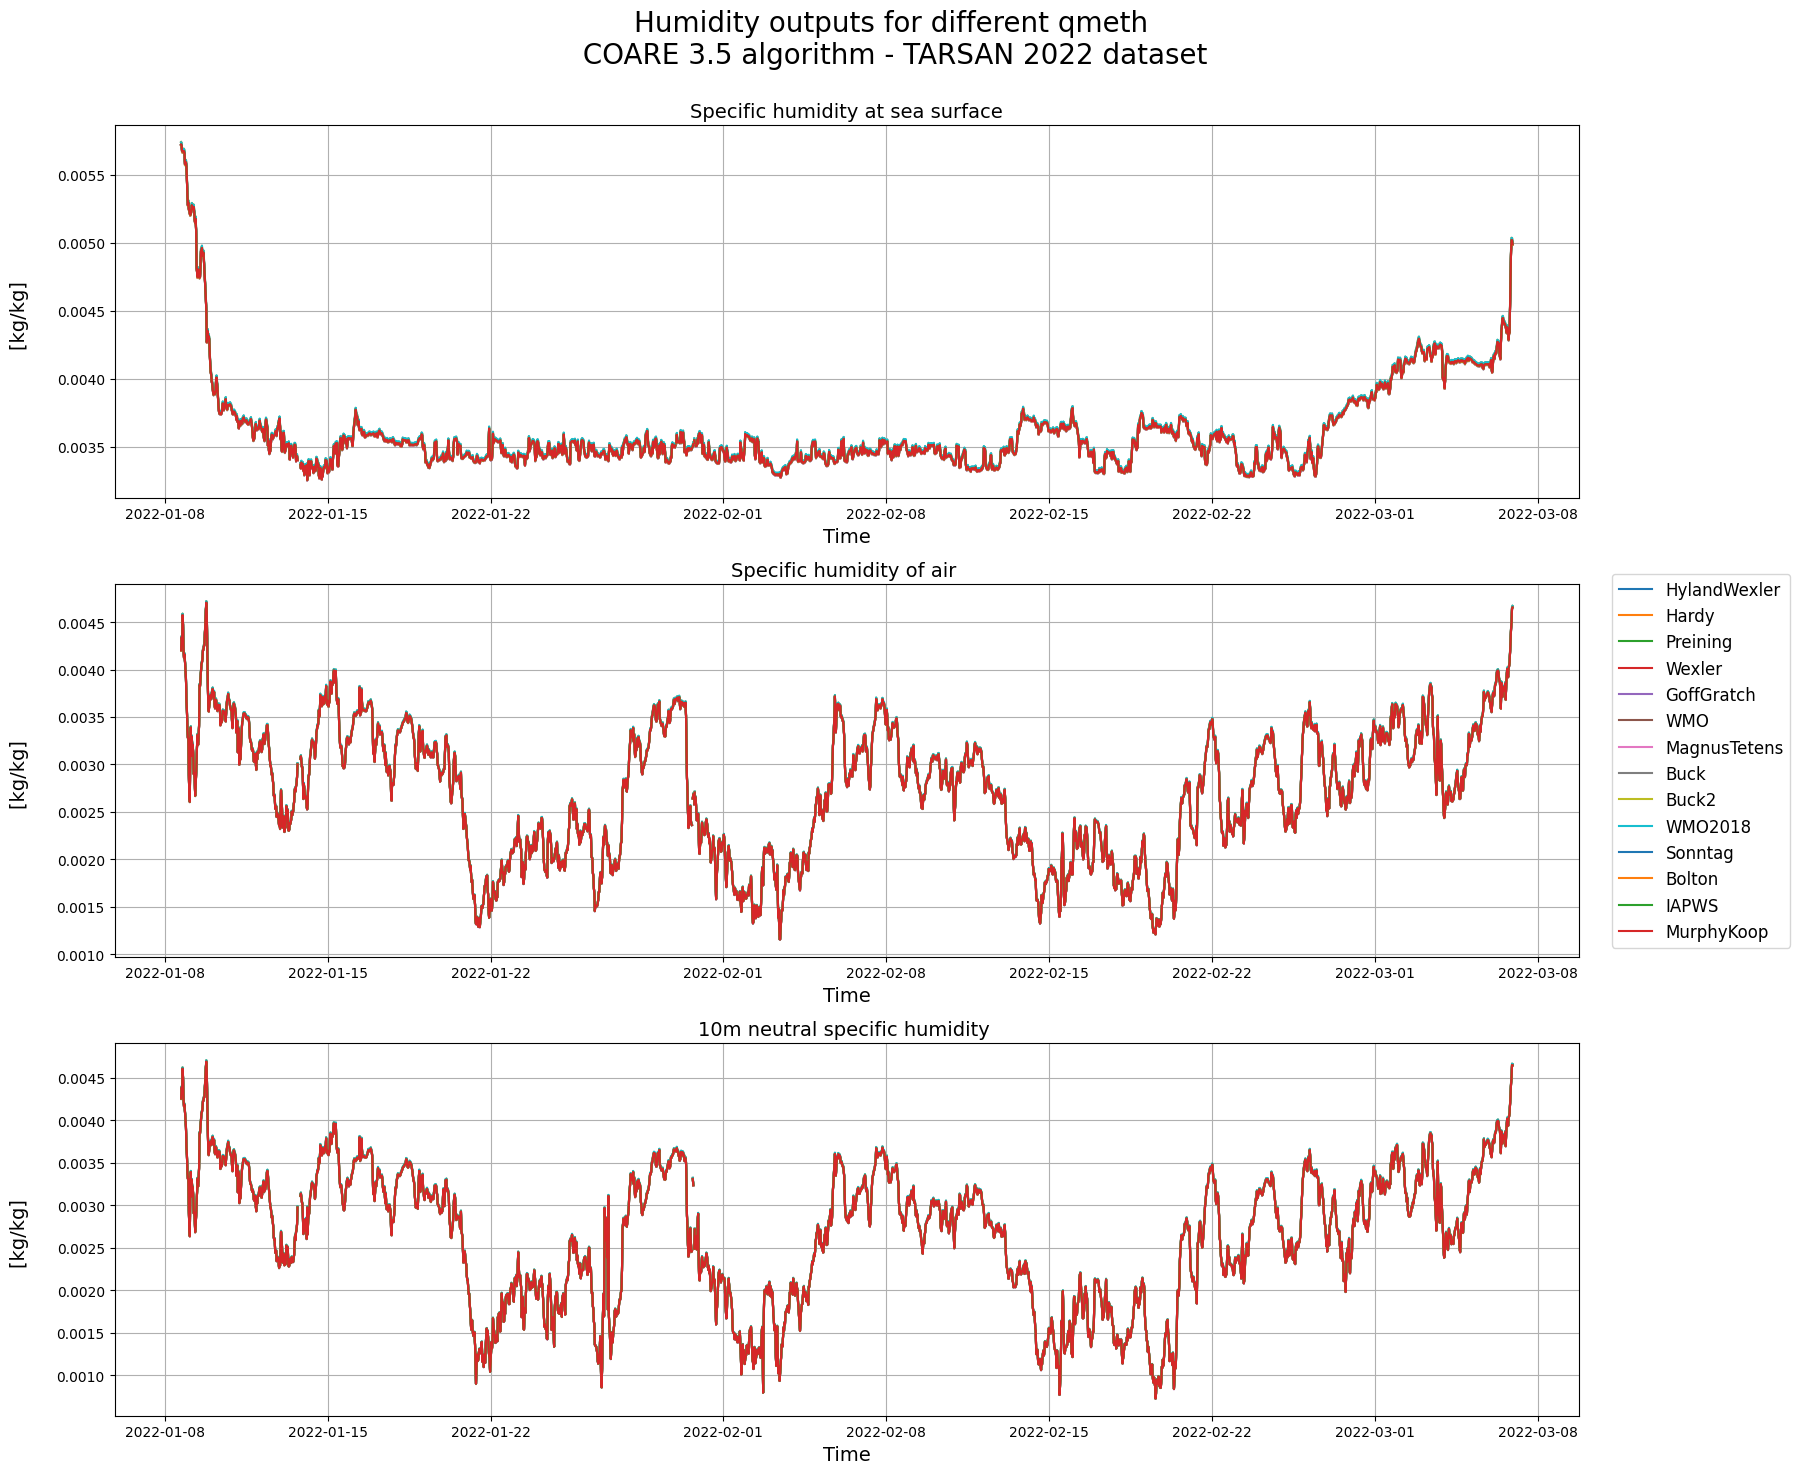

In [12]:
fig,ax= plt.subplots(nrows=3,ncols=1,figsize=(18,15))


plt.suptitle('Humidity outputs for different qmeth \n COARE 3.5 algorithm - TARSAN 2022 dataset \n',fontsize=20)

for qmeth in d:
    ax[0].plot(ds_tarsan_2022['Time'],d[qmeth]['qsea'],label=qmeth)
    ax[1].plot(ds_tarsan_2022['Time'],d[qmeth]['qair'],label=qmeth)
    ax[2].plot(ds_tarsan_2022['Time'],d[qmeth]['q10n'],label=qmeth)


ax[0].set_title('Specific humidity at sea surface', fontsize=14)

ax[1].set_title('Specific humidity of air ', fontsize=14)
ax[1].legend(ncols=1,bbox_to_anchor=(1.15,1.05),fontsize=12)

ax[2].set_title('10m neutral specific humidity ', fontsize=14)


for a in ax:
    a.grid()
    a.set_xlabel('Time',fontsize=14)
    a.set_ylabel('[kg/kg] \n',fontsize=14)
fig.tight_layout()


**Comments**: no difference visible. We will now compute the difference between the default method and the others.

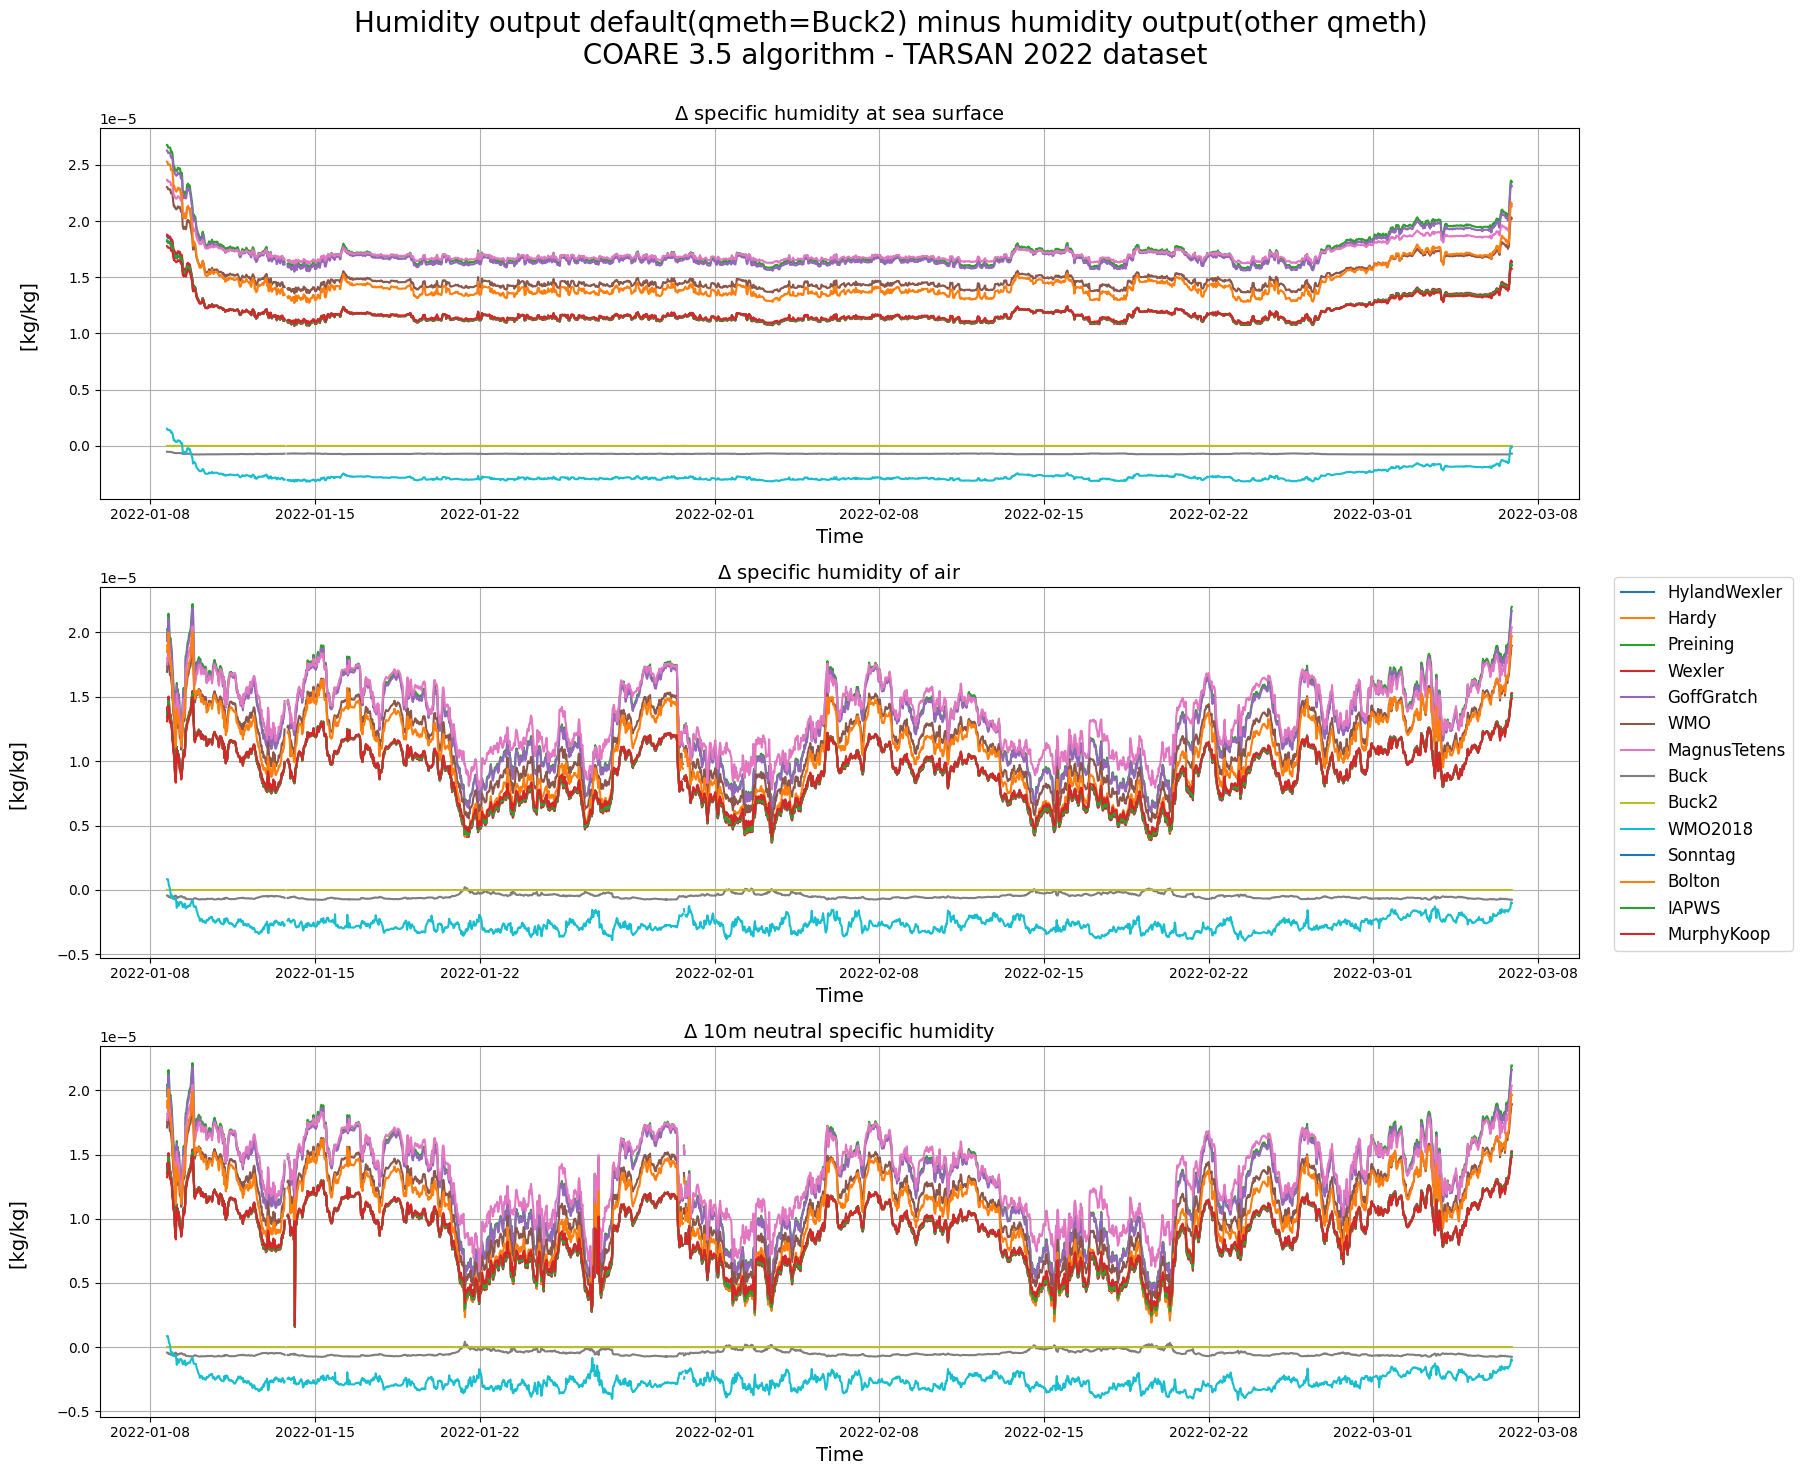

In [13]:
fig,ax= plt.subplots(nrows=3,ncols=1,figsize=(18,15))

plt.suptitle('Humidity output default(qmeth=Buck2) minus humidity output(other qmeth) \n COARE 3.5 algorithm - TARSAN 2022 dataset \n',fontsize=20)


for qmeth in d:
    ax[0].plot(ds_tarsan_2022['Time'],d['Buck2']['qsea']-d[qmeth]['qsea'],label=qmeth)
    ax[1].plot(ds_tarsan_2022['Time'],d['Buck2']['qair']-d[qmeth]['qair'],label=qmeth)
    ax[2].plot(ds_tarsan_2022['Time'],d['Buck2']['q10n']-d[qmeth]['q10n'],label=qmeth)

    
ax[0].set_title('$\Delta$ specific humidity at sea surface', fontsize=14)

ax[1].set_title('$\Delta$ specific humidity of air' ,fontsize=14)
ax[1].legend(ncols=1,bbox_to_anchor=(1.15,1.05),fontsize=12)

ax[2].set_title('$\Delta$ 10m neutral specific humidity',fontsize=14)

for a in ax:
    a.set_xlabel('Time',fontsize=14)
    a.set_ylabel('[kg/kg] \n',fontsize=14)
    a.grid()

fig.tight_layout()



**Comments**: We obserse the two same groups as for the latent heat flux result analyses.

We can quantify the effect in the same way as what was done for the latent heat flux above.

In [14]:
# cf table 2 Biri et al. 2023 
tol_q=10**(-5)
significance_q=10**(-4)

# cf Results section - 2nd paragraph Biri et al. 2023
bins = [-10**10,-5*significance_q,-significance_q,-tol_q,-0.1*tol_q, 0.1*tol_q, tol_q,significance_q,5*significance_q,10**10]
bins_label = ['major effect (-)','significant effect (-)','insignificant effect (-)','negligible effect (-)','no effect','negligible effect (+)','insignificant effect (+)','significant effect (+)','major effect (+)']



### $q_{sea}$

In [15]:
print('The following tables display the effect of chosing an alternative qmethod in comparison to the qmethod of reference (Buck2) on the specific humidity at the sea surface (qsea).\n'
      'The classification of the effect follows the one established in table 8 of the AirSeaFluxCode reference paper (Biri et al. 2023). \n'
      'The results of the effect are given as a count. For information, the total number of values is {}. \n \n'.format(len(ds_tarsan_2022['Time'])),
      file=open('./qsea_results.txt', 'w'))                   

print("Input summary", file=open('./qsea_results.txt', 'a'))                          
print('input file: {}, \n method: {}, \n sst type: {}, \n gustiness: {}, \n cskin: {},\n skin: {}, \n warm layer: {},'
      ' \n tolerance: {}, \n L: {},\n hout: {}, \n qmeth_ref: {}, \n \n'.format("jgofs_30minmean_2022.csv", "C35","bulk", "on",
                                                           1, "C35",1,"all", "tsrv","10","Buck2"),
      file=open('./qsea_results.txt', 'a'))



for qmeth in d:
    
    
    temp_stat = binned_statistic(d[qmeth]['qsea']-d['Buck2']['qsea'],d[qmeth]['qsea']- d['Buck2']['qsea'],
                             statistic='count', 
                             bins=bins)
    temp_data = {'Count': temp_stat.statistic}
   
                            
    ttl = np.asarray(["major effect (-)  ", "significant effect (-) ", "insignificant effect (-)", "negligible effect (-)", "no effect", "negligible effect (+)","insignificant effect (+)","significant effect (+)","major effect (+)"])

    header = ["Specific humidity at sea surface",qmeth]
    stats = np.copy(ttl)


    stats = np.c_[stats,temp_stat.statistic]                           


    print(tabulate(stats, headers=header, tablefmt="github", numalign="left",
                   floatfmt=("s", ".0f", "2f", "2f", "2f", "2f", "2f","2f","2f","2f")),
      file=open('./qsea_results.txt', 'a'))
    
    print('-'*79+'\n', file=open('./qsea_results.txt', 'a'))
    print('-'*79+'\n', file=open('./qsea_results.txt', 'a'))




### $q_{air}$

In [16]:
print('The following tables display the effect of chosing an alternative qmethod in comparison to the qmethod of reference (Buck2) on the specific humidity of air (qair).\n'
      'The classification of the effect follows the one established in table 8 of the AirSeaFluxCode reference paper (Biri et al. 2023). \n'
      'The results of the effect are given as a count. For information, the total number of values is {}. \n \n'.format(len(ds_tarsan_2022['Time'])),
      file=open('./qair_results.txt', 'w'))                   

print("Input summary", file=open('./qair_results.txt', 'a'))                          
print('input file: {}, \n method: {}, \n sst type: {}, \n gustiness: {}, \n cskin: {},\n skin: {}, \n warm layer: {},'
      ' \n tolerance: {}, \n L: {},\n hout: {}, \n qmeth_ref: {}, \n \n'.format("jgofs_30minmean_2022.csv", "C35","bulk", "on",
                                                           1, "C35",1,"all", "tsrv","10","Buck2"),
      file=open('./qair_results.txt', 'a'))



for qmeth in d:
    
    
    temp_stat = binned_statistic(d[qmeth]['qair']-d['Buck2']['qair'],d[qmeth]['qair']- d['Buck2']['qair'],
                             statistic='count', 
                             bins=bins)
    temp_data = {'Count': temp_stat.statistic}
   
                            
    ttl = np.asarray(["major effect (-)  ", "significant effect (-) ", "insignificant effect (-)", "negligible effect (-)", "no effect", "negligible effect (+)","insignificant effect (+)","significant effect (+)","major effect (+)"])

    header = ["Specific humidity of air",qmeth]
    stats = np.copy(ttl)


    stats = np.c_[stats,temp_stat.statistic]                           


    print(tabulate(stats, headers=header, tablefmt="github", numalign="left",
                   floatfmt=("s", ".0f", "2f", "2f", "2f", "2f", "2f","2f","2f","2f")),
      file=open('./qair_results.txt', 'a'))
    
    print('-'*79+'\n', file=open('./qair_results.txt', 'a'))
    print('-'*79+'\n', file=open('./qair_results.txt', 'a'))





### $q_{10n}$

In [17]:
print('The following tables display the effect of chosing an alternative qmethod in comparison to the qmethod of reference (Buck2) on the 10m neutral specific humidity (q10n).\n'
      'The classification of the effect follows the one established in table 8 of the AirSeaFluxCode reference paper (Biri et al. 2023). \n'
      'The results of the effect are given as a count. For information, the total number of values is {}. \n \n'.format(len(ds_tarsan_2022['Time'])),
      file=open('./q10n_results.txt', 'w'))                   

print("Input summary", file=open('./q10n_results.txt', 'a'))                          
print('input file: {}, \n method: {}, \n sst type: {}, \n gustiness: {}, \n cskin: {},\n skin: {}, \n warm layer: {},'
      ' \n tolerance: {}, \n L: {},\n hout: {}, \n qmeth_ref: {}, \n \n'.format("jgofs_30minmean_2022.csv", "C35","bulk", "on",
                                                           1, "C35",1,"all", "tsrv","10","Buck2"),
      file=open('./q10n_results.txt', 'a'))



for qmeth in d:
    
    
    temp_stat = binned_statistic(d[qmeth]['q10n']-d['Buck2']['q10n'],d[qmeth]['q10n']- d['Buck2']['q10n'],
                             statistic='count', 
                             bins=bins)
    temp_data = {'Count': temp_stat.statistic}
   
                            
    ttl = np.asarray(["major effect (-)  ", "significant effect (-) ", "insignificant effect (-)", "negligible effect (-)", "no effect", "negligible effect (+)","insignificant effect (+)","significant effect (+)","major effect (+)"])

    header = ["10m neutral specific humidity",qmeth]
    stats = np.copy(ttl)


    stats = np.c_[stats,temp_stat.statistic]                           


    print(tabulate(stats, headers=header, tablefmt="github", numalign="left",
                   floatfmt=("s", ".0f", "2f", "2f", "2f", "2f", "2f","2f","2f","2f")),
      file=open('./q10n_results.txt', 'a'))
    
    print('-'*79+'\n', file=open('./q10n_results.txt', 'a'))
    print('-'*79+'\n', file=open('./q10n_results.txt', 'a'))





# 4. Conclusion

 - AirSeaFlux code algorithm computes the specific humidity by applying a saturation vapour pressure function (see equation in the introduction of the notebook), the default one is Buck2.
- We used ship data from the TARSAN 2022 cruise in the Amundsen sea to investigate the effect of chosing an altnernative saturation vapour pressure function rather than the default one.
- To perform the investigation, we followed the method constructed in the AirSeaFlux code reference paper (Biri et al. 2023), which consists on a quantitative classification of the importance (major, significant, negligible,...) of the changes observed (same paper - see table 8).
- The findings are (see text files created) for the latent heat flux, the specific humidity at sea surface, the specific humidity of air and the 10m neutral specific humidity there is **no significant or major effect caused by a change of saturation vapour pressure function**.

We conclude that for the COARE 3.5 algorithm - with the TARSAN 2022 dataset - the use of one saturation vapour pressure function instead of another don't lead to significant and major effect and therefore we can conserve the default one or equivalentally pick another one.